In [1]:
import os
import anndata as an
import scanpy as sc
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
from deside.utility import (ExpObj, set_fig_style, sorted_cell_types, read_xy, get_corr, 
                            calculate_rmse, read_cancer_purity, check_dir, get_ccc)
from deside.utility.read_file import ReadExp, ReadH5AD
from sklearn.metrics import median_absolute_error
set_fig_style(font_family='Arial', font_size=8)

2024-09-13 22:02:07.145605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# download this file from https://github.com/OnlyBelter/DeSide_mini_example/blob/main/datasets/TCGA/tpm/tcga_sample_id2cancer_type.csv
sample_id2cancer_type = pd.read_csv('../../datasets/TCGA/tpm/tcga_sample_id2cancer_type.csv', index_col=0)
sample_id2cancer_type.head(2)

,cancer_type
TCGA-OR-A5LO-01A,ACC
TCGA-P6-A5OG-01A,ACC


### Only use the gene list in D1

In [3]:
# download this file from https://github.com/OnlyBelter/DeSide_mini_example/blob/main/datasets/simulated_bulk_cell_dataset/D1/gene_list_filtered_by_high_corr_gene_and_quantile_range.csv
d1_gene_list = pd.read_csv('gene_list_filtered_by_high_corr_gene_and_quantile_range.csv', index_col=0).index.tolist()
len(d1_gene_list)

9028

In [4]:
# download this file from https://doi.org/10.6084/m9.figshare.23047547.v2
tcga_obj = ReadExp('../../datasets/TCGA/tpm/merged_tpm.csv')
tcga_obj

In [5]:
tcga_obj.align_with_gene_list(gene_list=d1_gene_list, fill_not_exist=True)

   9028 common genes will be used, 10684 genes will be removed.


In [6]:
tcga_d1_genes = tcga_obj.get_exp()
tcga_d1_genes.head(2)

,A1BG,A2M,A4GALT,AADAT,AAGAB,AAMDC,AAMP,AARD,AASS,AATF,...,ZPBP2,ZPR1,ZRANB1,ZSCAN18,ZSWIM4,ZSWIM6,ZSWIM8,ZWINT,ZYX,ZZEF1
TCGA-OR-A5LO-01A,0.255,139.352,21.686,10.043,50.771,41.829,126.346,0.000,16.956,17.969,...,0.0,11.280,22.030,29.052,16.733,10.434,50.462,26.807,48.443,10.284
TCGA-P6-A5OG-01A,1.189,573.284,33.308,7.144,44.669,47.048,160.377,1.626,17.550,53.772,...,0.0,67.377,10.584,17.853,14.111,61.047,23.259,151.146,317.842,12.420


In [7]:
si2ct = sample_id2cancer_type.to_dict()['cancer_type']
tcga_d1_genes['cancer_type'] = tcga_d1_genes.index.map(lambda x: si2ct[x])
tcga_d1_genes.head(2)

,A1BG,A2M,A4GALT,AADAT,AAGAB,AAMDC,AAMP,AARD,AASS,AATF,...,ZPR1,ZRANB1,ZSCAN18,ZSWIM4,ZSWIM6,ZSWIM8,ZWINT,ZYX,ZZEF1,cancer_type
TCGA-OR-A5LO-01A,0.255,139.352,21.686,10.043,50.771,41.829,126.346,0.000,16.956,17.969,...,11.280,22.030,29.052,16.733,10.434,50.462,26.807,48.443,10.284,ACC
TCGA-P6-A5OG-01A,1.189,573.284,33.308,7.144,44.669,47.048,160.377,1.626,17.550,53.772,...,67.377,10.584,17.853,14.111,61.047,23.259,151.146,317.842,12.420,ACC


/var/folders/qj/vrg9kck17g3bhjcg9bf6yk8m0000gp/T/ipykernel_55860/3445440100.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.hist(tcga_d1_genes.sum(axis=1), bins=30)


(array([1.000e+00, 0.000e+00, 2.000e+00, 4.000e+00, 9.600e+01, 2.292e+03,
        4.548e+03, 7.280e+02, 1.800e+01, 4.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 999999.678     ,  999999.72923333,  999999.78046666,
         999999.8317    ,  999999.88293333,  999999.93416666,
         999999.9854    , 1000000.03663333, 1000000.08786667,
        1000000.1391    , 1000000.19033333, 1000000.24156667,
        1000000.2928    , 1000000.34403333, 1000000.39526667,
        1000000.4465    , 1000000.49773333, 1000000.54896667,
        1000000.6002    , 1000000.65143333, 1000000.70266667,
        1000000.7539    , 1000000.80513333, 1000000.85636667,
        1000000.9076    , 1000000.95883333, 1000001.01006667,
        1000001.0613    , 1000001.11253333, 1000001.16376667,
        

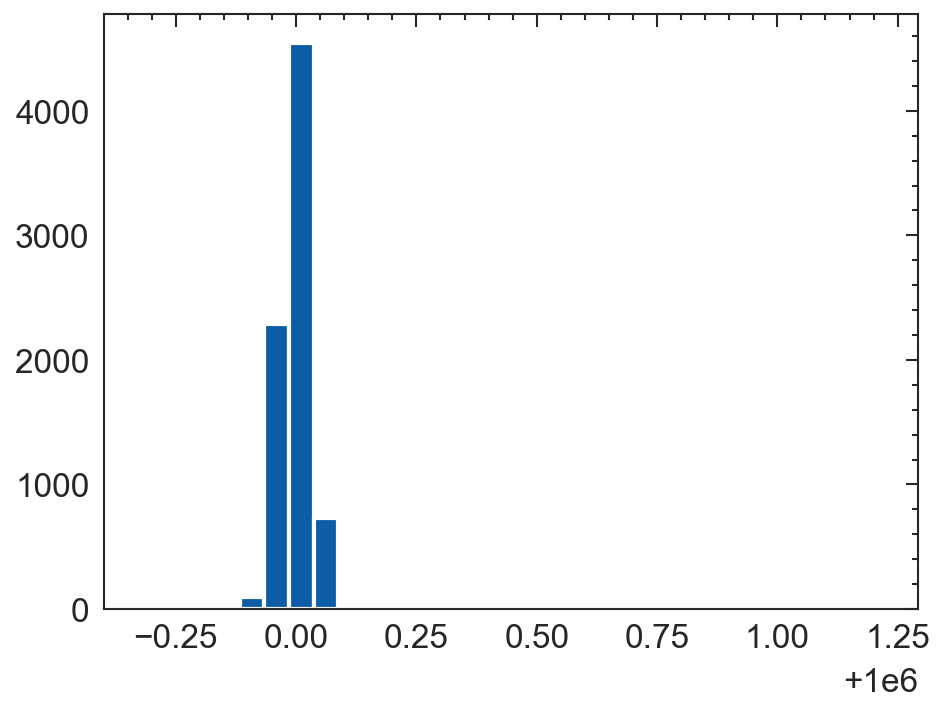

In [8]:
plt.hist(tcga_d1_genes.sum(axis=1), bins=30)

In [9]:
mean_exp_by_ct = tcga_d1_genes.groupby('cancer_type').mean()
mean_exp_by_ct.head(2)

,A1BG,A2M,A4GALT,AADAT,AAGAB,AAMDC,AAMP,AARD,AASS,AATF,...,ZPBP2,ZPR1,ZRANB1,ZSCAN18,ZSWIM4,ZSWIM6,ZSWIM8,ZWINT,ZYX,ZZEF1
cancer_type,,,,,,,,,,,,,,,,,,,,,
ACC,0.394785,398.047937,25.958987,3.156481,53.009013,120.905911,131.654456,5.376709,6.405038,38.708557,...,0.088494,16.033696,12.215190,23.253418,11.951734,9.948468,38.074557,44.095987,93.379139,11.139519
BLCA,0.234150,314.644740,66.821495,15.360723,69.132924,33.022804,189.840885,1.385865,5.926608,82.824076,...,0.151211,32.883316,10.397137,13.008044,26.813260,12.860618,33.628529,100.901676,293.928262,13.460306


In [10]:
mean_exp_by_ct.sum(axis=1)

cancer_type
ACC     1.000000e+06
BLCA    1.000000e+06
BRCA    1.000000e+06
CESC    1.000000e+06
COAD    1.000000e+06
GBM     1.000000e+06
HNSC    1.000000e+06
KICH    1.000000e+06
KIRC    1.000000e+06
KIRP    1.000000e+06
LGG     1.000000e+06
LIHC    1.000000e+06
LUAD    1.000000e+06
LUSC    1.000000e+06
PAAD    1.000000e+06
PRAD    1.000000e+06
READ    1.000000e+06
THCA    1.000000e+06
UCEC    1.000000e+06
dtype: float64

### D1

In [11]:
# download D1 from https://doi.org/10.6084/m9.figshare.23047391.v2
d1 = ReadH5AD('../../datasets/simulated_bulk_cell_dataset_subtypes_all_range/segment_12ds_0.95_n_base100_19cancer_pca_0.9_median_gep/simu_bulk_exp_Mixed_N100K_segment_log2cpm1p_filtered_by_high_corr_gene_and_quantile_range_q_0.5_q_99.5.h5ad')
d1

In [12]:
d1_df = d1.get_df()
d1_obj = ReadExp(d1_df, exp_type='log_space')
d1_obj.to_tpm()
d1_tpm = d1_obj.get_exp()
print(d1_tpm.shape)
d1_tpm.head(2)

(100000, 9028)


,A1BG,A2M,A4GALT,AADAT,AAGAB,AAMDC,AAMP,AARD,AASS,AATF,...,ZPBP2,ZPR1,ZRANB1,ZSCAN18,ZSWIM4,ZSWIM6,ZSWIM8,ZWINT,ZYX,ZZEF1
s_segment_0_1008,98.179,1244.030,44.790,7.044,26.435,85.341,89.696,2.195,38.341,49.317,...,0.0,7.248,21.975,52.742,9.418,21.879,34.926,8.673,143.004,21.192
s_segment_0_101,60.610,620.706,25.012,3.672,27.563,73.084,118.933,3.949,13.806,63.628,...,0.0,33.947,37.401,39.987,13.085,32.384,36.248,39.591,153.674,21.739


In [13]:
d1_mean = d1_tpm.mean(axis=0)
d1_mean.sum()

1000000.82382723

### D2

In [14]:
del tcga_obj, tcga_d1_genes, d1, d1_df, d1_obj, d1_tpm

In [15]:
# download D2 from https://doi.org/10.6084/m9.figshare.23284256.v2
d2 = ReadH5AD('../../datasets/simulated_bulk_cell_dataset_subtypes_all_range/segment_12ds_no_filtering_n_base100_median_gep/simu_bulk_exp_Mixed_N100K_segment_without_filtering_log2cpm1p.h5ad')
d2_df = d2.get_df()
d2_obj = ReadExp(d2_df, exp_type='log_space')
d2_obj.to_tpm()

In [16]:
d2_obj.align_with_gene_list(gene_list=d1_gene_list, fill_not_exist=True)
d2_tpm = d2_obj.get_exp()
print(d2_tpm.shape)
d2_tpm.head(2)

   9028 common genes will be used, 8806 genes will be removed.
(100000, 9028)


,A1BG,A2M,A4GALT,AADAT,AAGAB,AAMDC,AAMP,AARD,AASS,AATF,...,ZPBP2,ZPR1,ZRANB1,ZSCAN18,ZSWIM4,ZSWIM6,ZSWIM8,ZWINT,ZYX,ZZEF1
s_segment_0_1,88.312,872.060,35.778,4.570,26.331,78.196,107.366,1.209,24.690,87.939,...,0.0,29.902,34.451,47.549,19.499,22.366,35.649,12.016,136.831,24.111
s_segment_0_10,109.891,15.234,2.338,0.148,17.116,62.427,105.266,11.292,10.153,87.915,...,0.0,41.786,30.793,26.063,74.478,18.917,32.965,2.984,113.191,33.819


In [17]:
d2_mean = d2_tpm.mean(axis=0)
d2_mean.sum()

999999.98669

In [18]:
np.all(mean_exp_by_ct.columns == d1_mean.index)

True

In [19]:
np.all(mean_exp_by_ct.columns == d2_mean.index)

True

In [20]:
d1_mean_df = d1_mean.to_frame()
d1_mean_df['D1'] = d1_mean_df[0]
d1_mean_df.drop(columns=[0], inplace=True)
d1_mean_df = d1_mean_df.T
d1_mean_df

,A1BG,A2M,A4GALT,AADAT,AAGAB,AAMDC,AAMP,AARD,AASS,AATF,...,ZPBP2,ZPR1,ZRANB1,ZSCAN18,ZSWIM4,ZSWIM6,ZSWIM8,ZWINT,ZYX,ZZEF1
D1,68.927111,569.235156,25.097539,5.487424,28.84389,83.514154,106.211456,2.984929,16.953545,70.606852,...,0.047568,24.483313,30.133382,38.316164,15.482936,31.394857,28.462313,28.904848,137.165759,23.179104


In [21]:
d2_mean_df = d2_mean.to_frame()
d2_mean_df['D2'] = d2_mean_df[0]
d2_mean_df.drop(columns=[0], inplace=True)
d2_mean_df = d2_mean_df.T
d2_mean_df

,A1BG,A2M,A4GALT,AADAT,AAGAB,AAMDC,AAMP,AARD,AASS,AATF,...,ZPBP2,ZPR1,ZRANB1,ZSCAN18,ZSWIM4,ZSWIM6,ZSWIM8,ZWINT,ZYX,ZZEF1
D2,84.136701,444.215925,16.173832,2.228541,26.015273,53.097616,90.180287,2.272359,10.319812,77.66797,...,0.113914,36.861105,30.73337,32.564961,17.582646,36.008881,32.515417,15.539485,178.496581,33.214094


In [22]:
mean_exp_all = pd.concat([mean_exp_by_ct, d1_mean_df, d2_mean_df])
mean_exp_all.shape

(21, 9028)

In [23]:
mean_exp_all.head(2)

,A1BG,A2M,A4GALT,AADAT,AAGAB,AAMDC,AAMP,AARD,AASS,AATF,...,ZPBP2,ZPR1,ZRANB1,ZSCAN18,ZSWIM4,ZSWIM6,ZSWIM8,ZWINT,ZYX,ZZEF1
ACC,0.394785,398.047937,25.958987,3.156481,53.009013,120.905911,131.654456,5.376709,6.405038,38.708557,...,0.088494,16.033696,12.215190,23.253418,11.951734,9.948468,38.074557,44.095987,93.379139,11.139519
BLCA,0.234150,314.644740,66.821495,15.360723,69.132924,33.022804,189.840885,1.385865,5.926608,82.824076,...,0.151211,32.883316,10.397137,13.008044,26.813260,12.860618,33.628529,100.901676,293.928262,13.460306


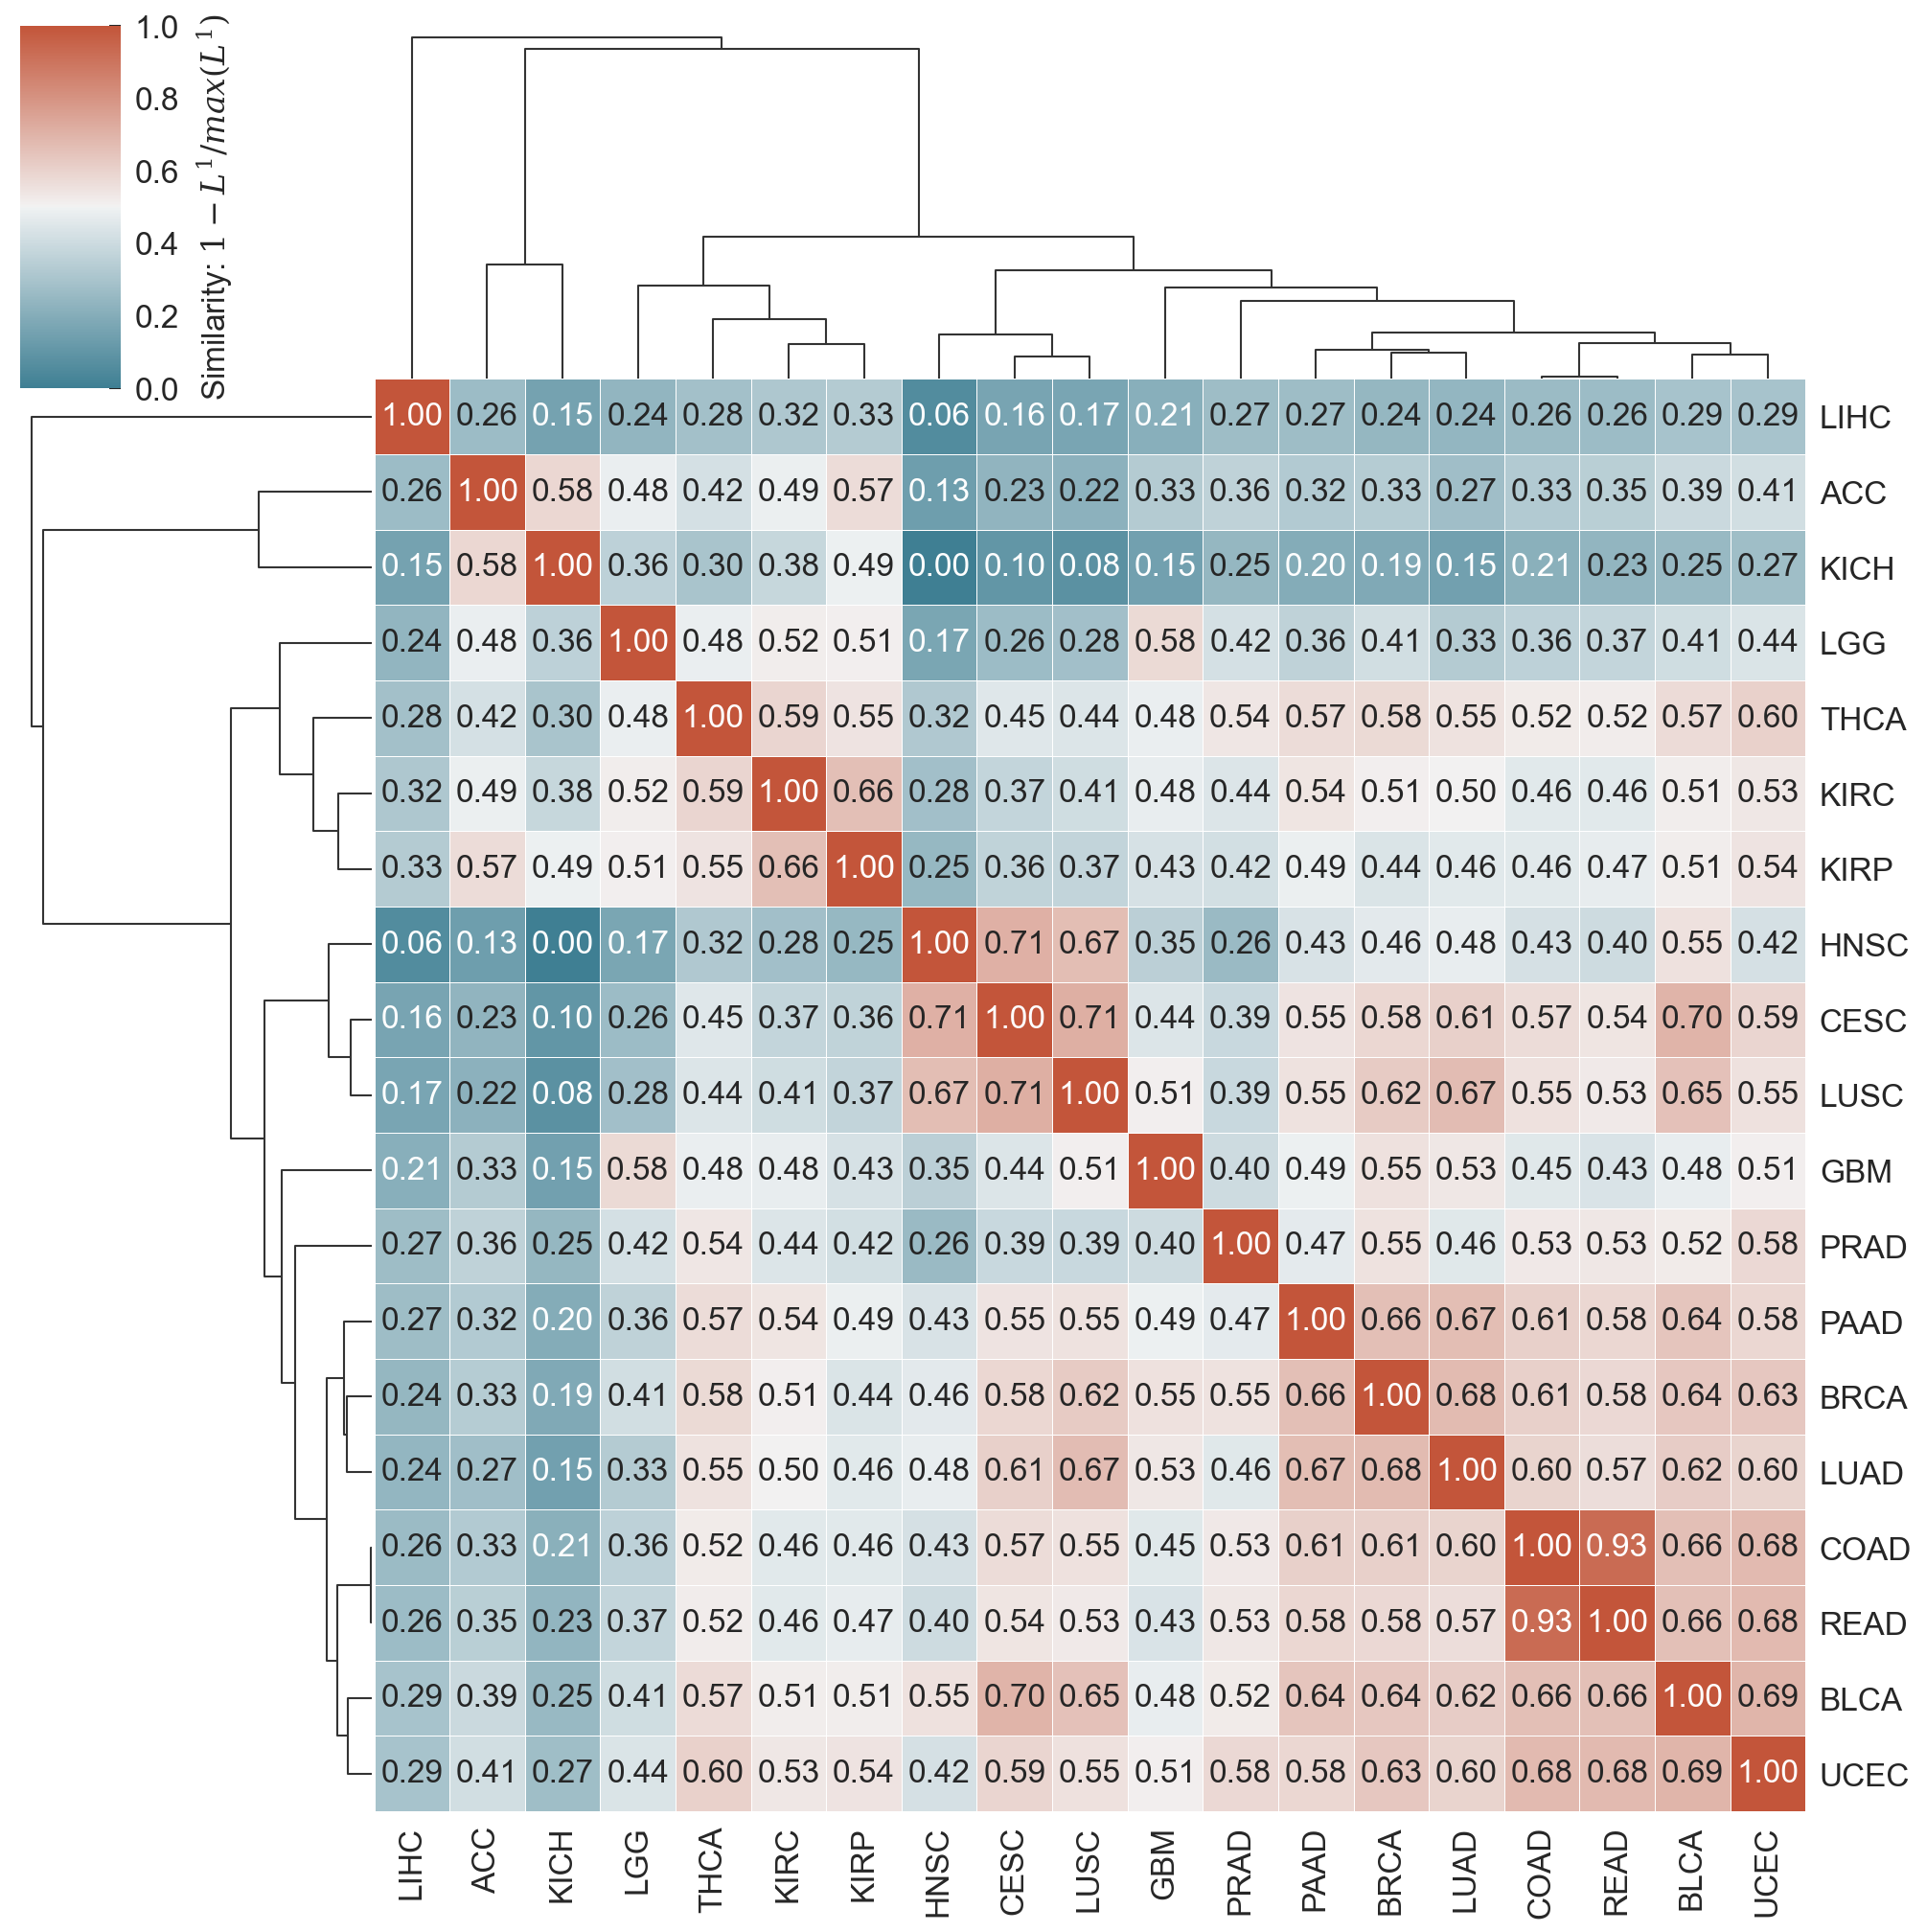

In [24]:
# Calculate L1 distance
distance = pairwise_distances(mean_exp_by_ct, metric='l1')

l1_similarity = 1 - distance/distance.max()

# Convert to a pandas DataFrame for better labeling
df_l1_sim = pd.DataFrame(l1_similarity,
                         index=mean_exp_by_ct.index,
                         columns=mean_exp_by_ct.index)

# Set up the matplotlib figure
# fig, ax1 = plt.subplots(figsize=(7, 7))

# Create the clustermap
cmap = sns.diverging_palette(220, 20, as_cmap=True)
g = sns.clustermap(df_l1_sim, 
                   cmap=cmap,
                   vmin=0, vmax=1,  # Cosine similarity ranges from 0 to 1
                   center=0.5,
                   metric="cosine",  # Use cosine distance for clustering
                   linewidths=0.2,
                   figsize=(7,7),
                   annot=True,  # Annotate the cells with values
                   fmt=".2f",  # Format annotations to 2 decimal places
                   cbar_kws={"label": "Similarity: $1-L^1/max(L^1)$"})

# Set the title
# plt.suptitle("Cosine Similarity Clustermap", fontsize=16)
# Set xlabel
g.ax_heatmap.set_xlabel("")
# Set ylabel (optional, for symmetry)
g.ax_heatmap.set_ylabel("")
# plt.tight_layout()
# plt.show()
plt.savefig('cancer_type_cluster_using_d1_genes2.svg', dpi=300)

In [25]:
mean_exp_all_t = mean_exp_all.T.copy()
mean_exp_all_t['D1+D2'] = mean_exp_all_t.loc[:, ['D1', 'D2']].mean(axis=1)
mean_exp_all_t.drop(columns=['D1', 'D2'], inplace=True)
mean_exp_all2 = mean_exp_all_t.T.copy()
mean_exp_all2.head(2)

,A1BG,A2M,A4GALT,AADAT,AAGAB,AAMDC,AAMP,AARD,AASS,AATF,...,ZPBP2,ZPR1,ZRANB1,ZSCAN18,ZSWIM4,ZSWIM6,ZSWIM8,ZWINT,ZYX,ZZEF1
ACC,0.394785,398.047937,25.958987,3.156481,53.009013,120.905911,131.654456,5.376709,6.405038,38.708557,...,0.088494,16.033696,12.215190,23.253418,11.951734,9.948468,38.074557,44.095987,93.379139,11.139519
BLCA,0.234150,314.644740,66.821495,15.360723,69.132924,33.022804,189.840885,1.385865,5.926608,82.824076,...,0.151211,32.883316,10.397137,13.008044,26.813260,12.860618,33.628529,100.901676,293.928262,13.460306


In [26]:
# Calculate L1 distance
distance = pairwise_distances(mean_exp_all2, metric='l1')

l1_similarity = 1 - distance/distance.max()

# Convert to a pandas DataFrame for better labeling
df_l1_sim = pd.DataFrame(l1_similarity,
                         index=mean_exp_all2.index,
                         columns=mean_exp_all2.index)

df_l1_sim.head(2)

,ACC,BLCA,BRCA,CESC,COAD,GBM,HNSC,KICH,KIRC,KIRP,LGG,LIHC,LUAD,LUSC,PAAD,PRAD,READ,THCA,UCEC,D1+D2
ACC,1.000000,0.466556,0.414342,0.327212,0.408344,0.412128,0.239827,0.633994,0.548452,0.620551,0.546169,0.354963,0.363663,0.316195,0.407379,0.438146,0.426479,0.489499,0.483912,0.114916
BLCA,0.466556,1.000000,0.680606,0.733315,0.702027,0.541550,0.607011,0.342070,0.572173,0.573668,0.480027,0.379878,0.667129,0.696292,0.685423,0.581172,0.700488,0.623381,0.729358,0.308386


In [27]:
df_l1_sim_d1d2 = df_l1_sim.loc[~df_l1_sim.index.isin(['D1', 'D2', 'D1+D2']), ['D1+D2']].copy()
df_l1_sim_d1d2['cancer_type'] = df_l1_sim_d1d2.index
df_l1_sim_d1d2 = df_l1_sim_d1d2.sort_values(by=['D1+D2'], ascending=True)
df_l1_sim_d1d2.head(2)

,D1+D2,cancer_type
KICH,0.00000,KICH
LIHC,0.05003,LIHC


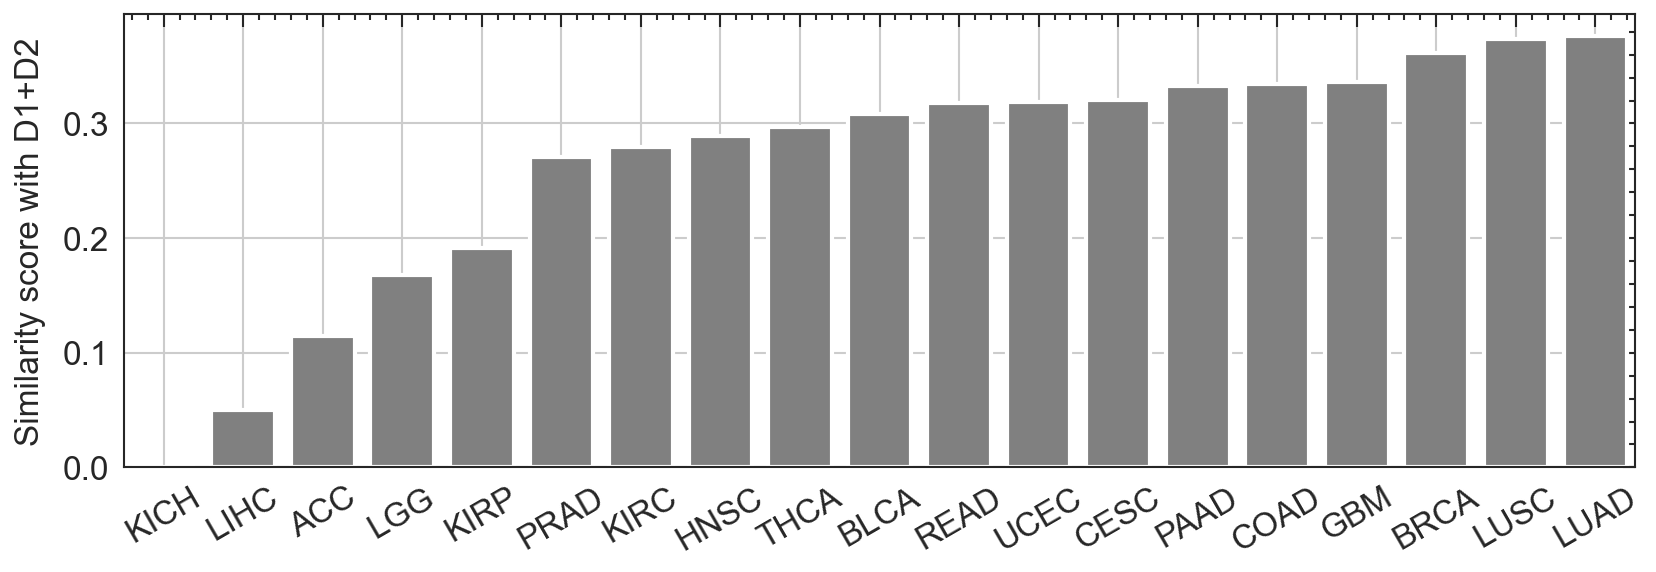

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 2.))

sns.barplot(data=df_l1_sim_d1d2, x='cancer_type', y='D1+D2', color='gray')

ax.set_ylabel('Similarity score with D1+D2')
ax.set_xticks(range(19), df_l1_sim_d1d2.index.to_list(), rotation=30, fontsize=8)
ax.set_xlabel('')
# ax.set_yticks([0, 0.3, 0.6, 0.9])
ax.grid()
# ax.legend(fontsize=6, loc='best', ncol=2)

plt.savefig('similarity_d1d2_with_TCGA2.svg', dpi=300)